# Visualization of K-Means applied on features

In [1]:
import cv2 as cv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import src
from src.data_generation.utils import downsample_img, normalize_img
from src.hierarchical_properties.clustering import k_means_on_feature, \
    ward_on_feature
import importlib

importlib.reload(src.hierarchical_properties.clustering)
from src.hierarchical_properties.clustering import k_means_on_feature, \
    ward_on_feature

In [3]:
def get_idx_img_and_blocks_from_batch(batch_images, blocks_paths, idx):
    img = batch_images[idx, ...]

    print(img.shape)
    features = []
    for i in range(len(blocks_paths)):
        blocks_i = np.load(blocks_paths[i])
        feature_i = blocks_i[idx, ...]
        features.append(feature_i)
    return img, features

In [4]:
# Constants
img_batch_path = r"../../data/dog_batch/dog.npy"
batch_size = 2

full_size = 448
patch_sizes = [112, 56, 28, 14]
n_channels_patches = [512, 1024, 2048, 4096]
blocks_batch_paths = ["../../data/dog_batch/v2_block1.npy",
                      "../../data/dog_batch/v2_block2.npy",
                      "../../data/dog_batch/v2_block3.npy",
                      "../../data/dog_batch/v2_block4.npy"]

batch_images = np.load(img_batch_path)

# K-Means
k_s = [2, 4, 6, 8] #[2, 3, 4, 5, 6, 7, 8, 9, 10]
max_iter = 300
epsilon = 0.0001
attempts = 10
normalize = True
bilinear_interpolation_flag = cv.INTER_LINEAR
nn_interpolation_flag = cv.INTER_NEAREST

weight_original_img = 0.4
weight_colored_patch = 0.4
gamma = 0

In [5]:
for patch_path in blocks_batch_paths:
    patch = np.load(patch_path)
    print(patch.shape)

(2, 112, 112, 512)
(2, 56, 56, 1024)
(2, 28, 28, 2048)
(2, 14, 14, 4096)


(448, 448, 3)


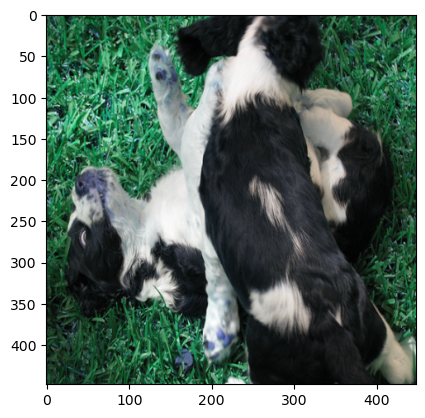

(448, 448, 3)


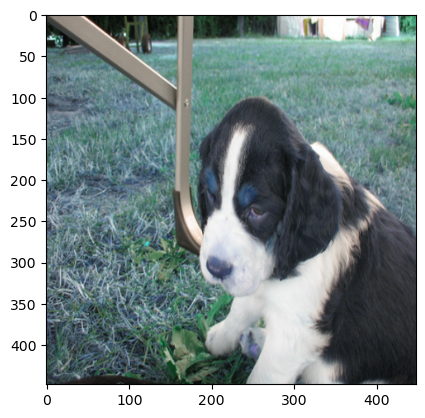

In [6]:
final_images_bilinear_interp = {}
final_images_nn_interp = {}
# Sum of squared distance from each point to their corresponding centers.
# Each element corresponds to a different number of clusters.
compactness_k_dict = {}


for idx_batch_sample in range(batch_size):
    final_images_bilinear_interp[idx_batch_sample] = []
    final_images_nn_interp[idx_batch_sample] = []

    img, features = get_idx_img_and_blocks_from_batch(
        batch_images, blocks_batch_paths, idx_batch_sample)

    img = downsample_img(img, full_size, full_size, False)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = normalize_img(img, min_value=0, max_value=255,
                        return_int_values=True)
    plt.imshow(img)
    plt.show()
    j = 0
    for idx_block in range(len(blocks_batch_paths)):
        feature = features[idx_block]
        #patch = cv.cvtColor(patch, cv.COLOR_BGR2RGB)
        # Initialize dict that will contain compactness values for each k for
        # each patch
        compactness_k_dict[idx_batch_sample, j] = []
        for k in k_s:
            seg_patch, compactness = k_means_on_feature(
                feature, n_clusters=k, max_iter=max_iter, epsilon=epsilon,
                attempts=attempts, normalize=normalize,
                n_channels=n_channels_patches[j], plot=False)
            compactness_k_dict[idx_batch_sample, j].append(compactness)
            seg_full = downsample_img(
                seg_patch, full_size, full_size, False,
                interpolation_method=bilinear_interpolation_flag)

            # Convert the original image as grayscale image to put it in the
            # background to be able to put the patch (the output of Kmeans)
            # over it in a transparent way.
            # Single channel grayscale image
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            # Repeat the grayscale image along all the 3 channels
            stacked_img = np.stack((img_gray,) * 3, axis=-1)

            final_img_bilinear_interp = cv.addWeighted(
                stacked_img, weight_original_img, seg_full, weight_colored_patch,
                gamma)
            final_images_bilinear_interp[idx_batch_sample].append(
                final_img_bilinear_interp)

            seg_full_nearest_neighbor_interp = downsample_img(
                seg_patch, full_size, full_size, False,
                interpolation_method=nn_interpolation_flag)

            nearest_neighbor_interp_final_img = cv.addWeighted(
                stacked_img, weight_original_img,
                seg_full_nearest_neighbor_interp,
                weight_colored_patch, gamma)
            final_images_nn_interp[idx_batch_sample].append(
                nearest_neighbor_interp_final_img)
        j += 1

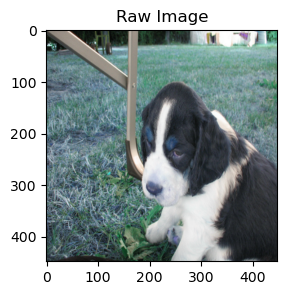

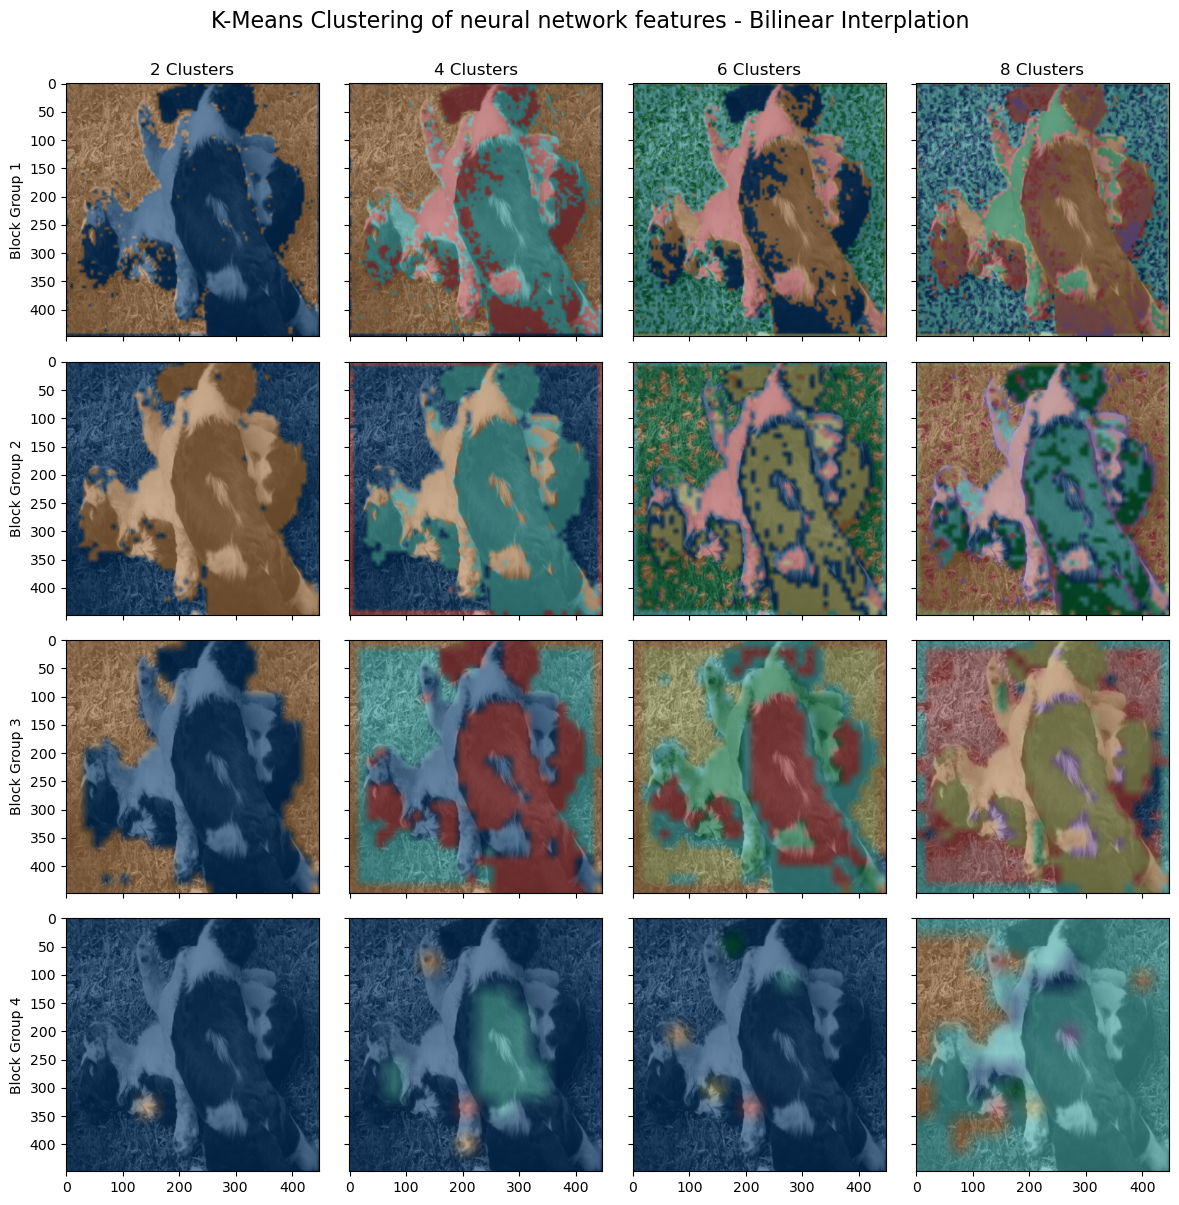

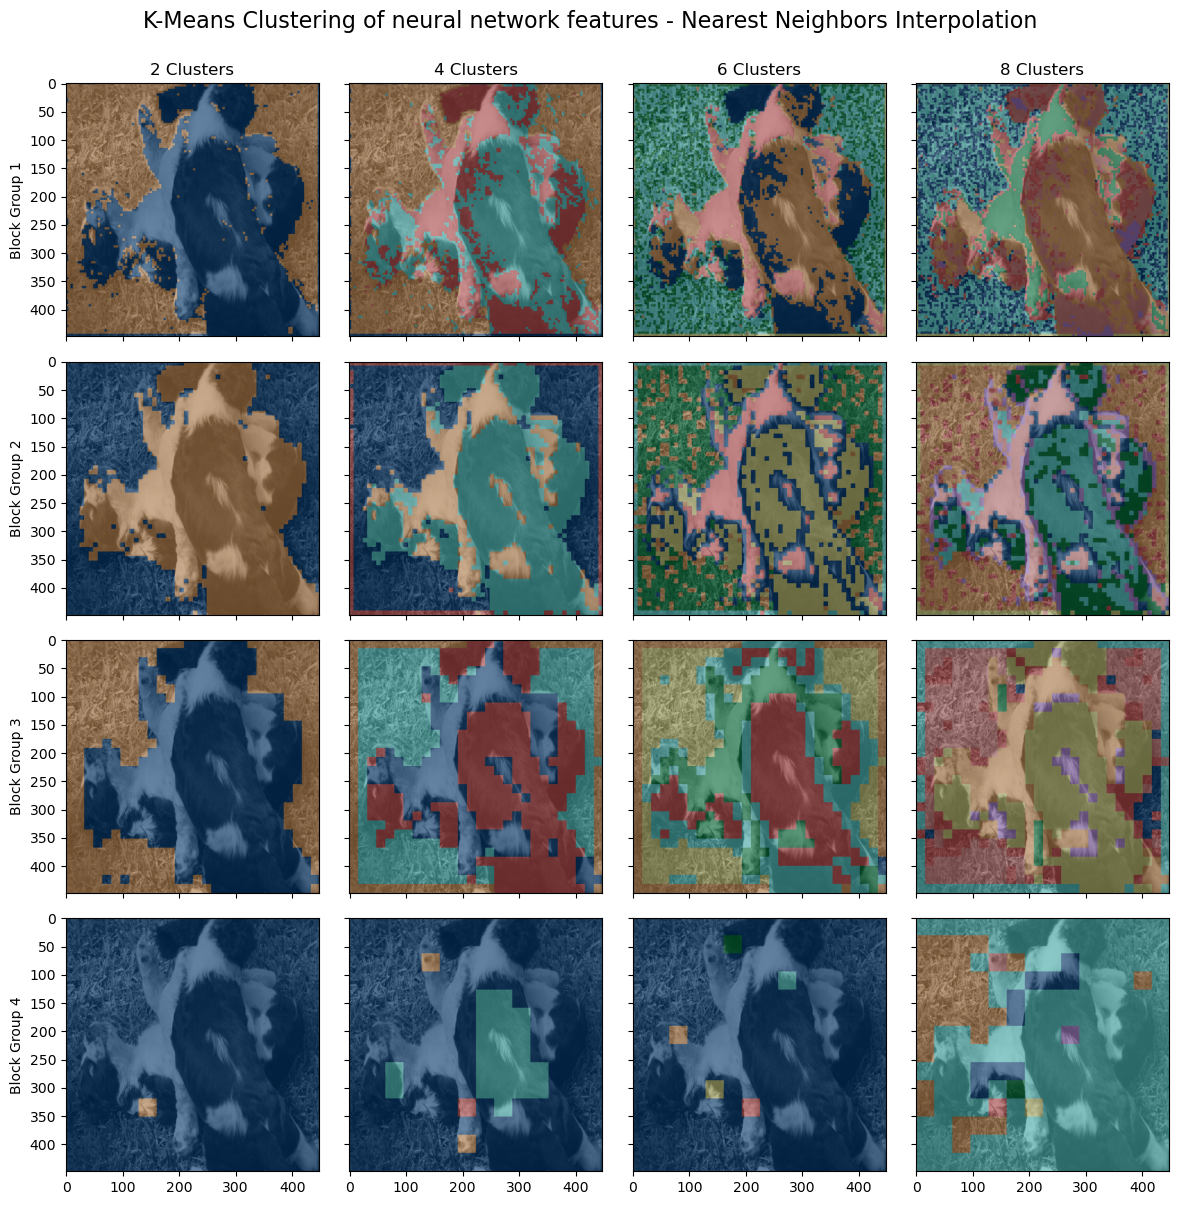

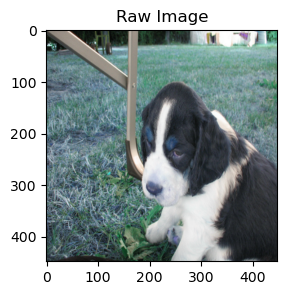

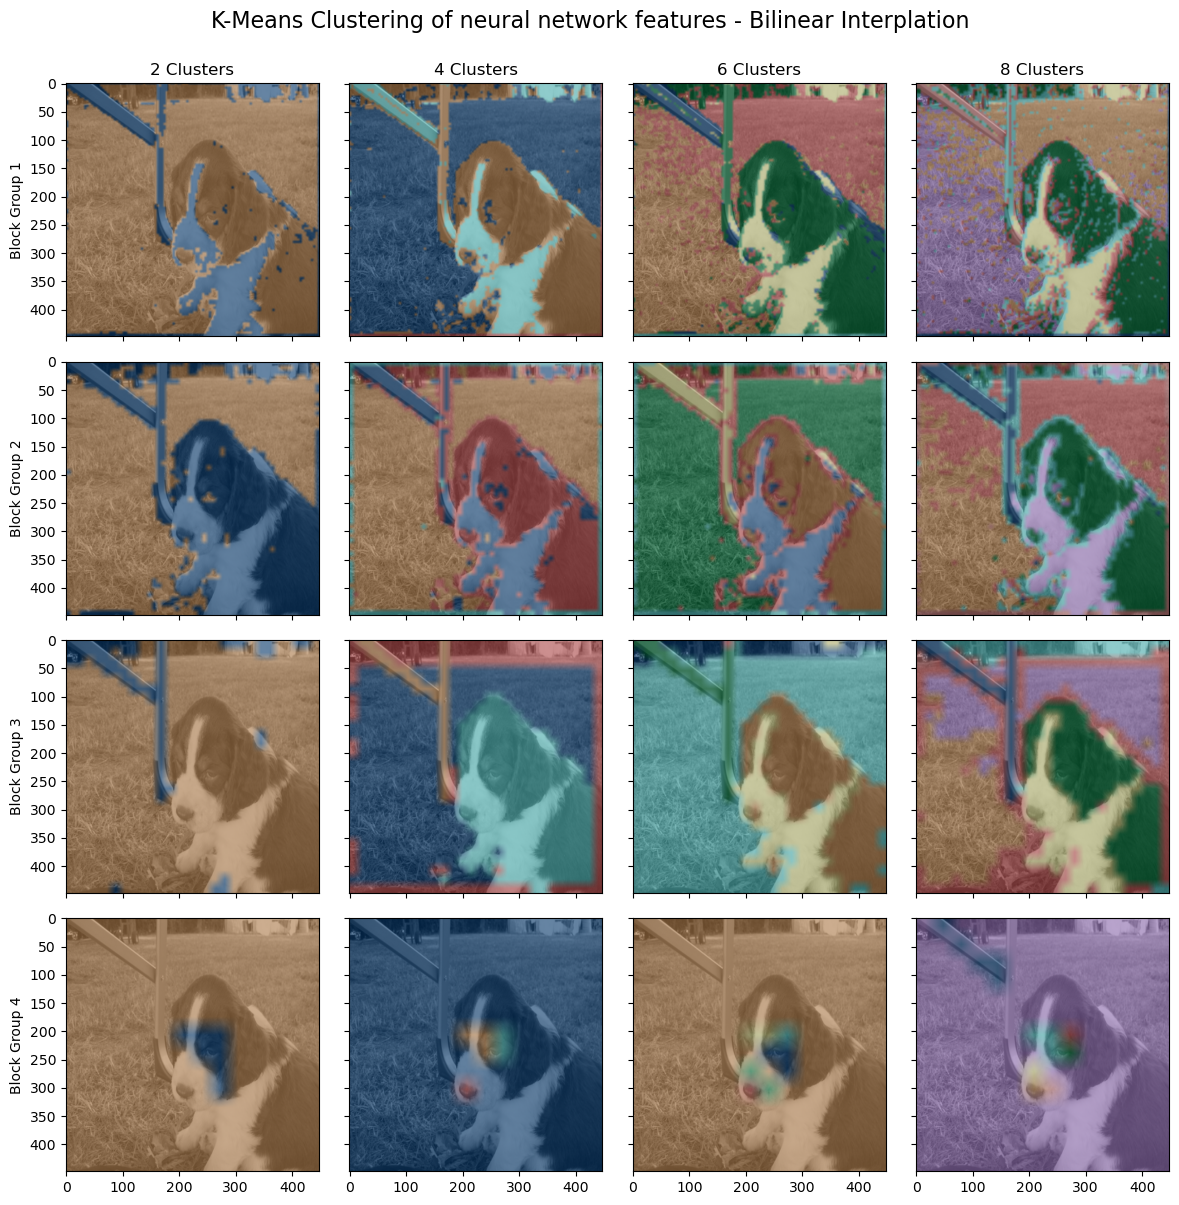

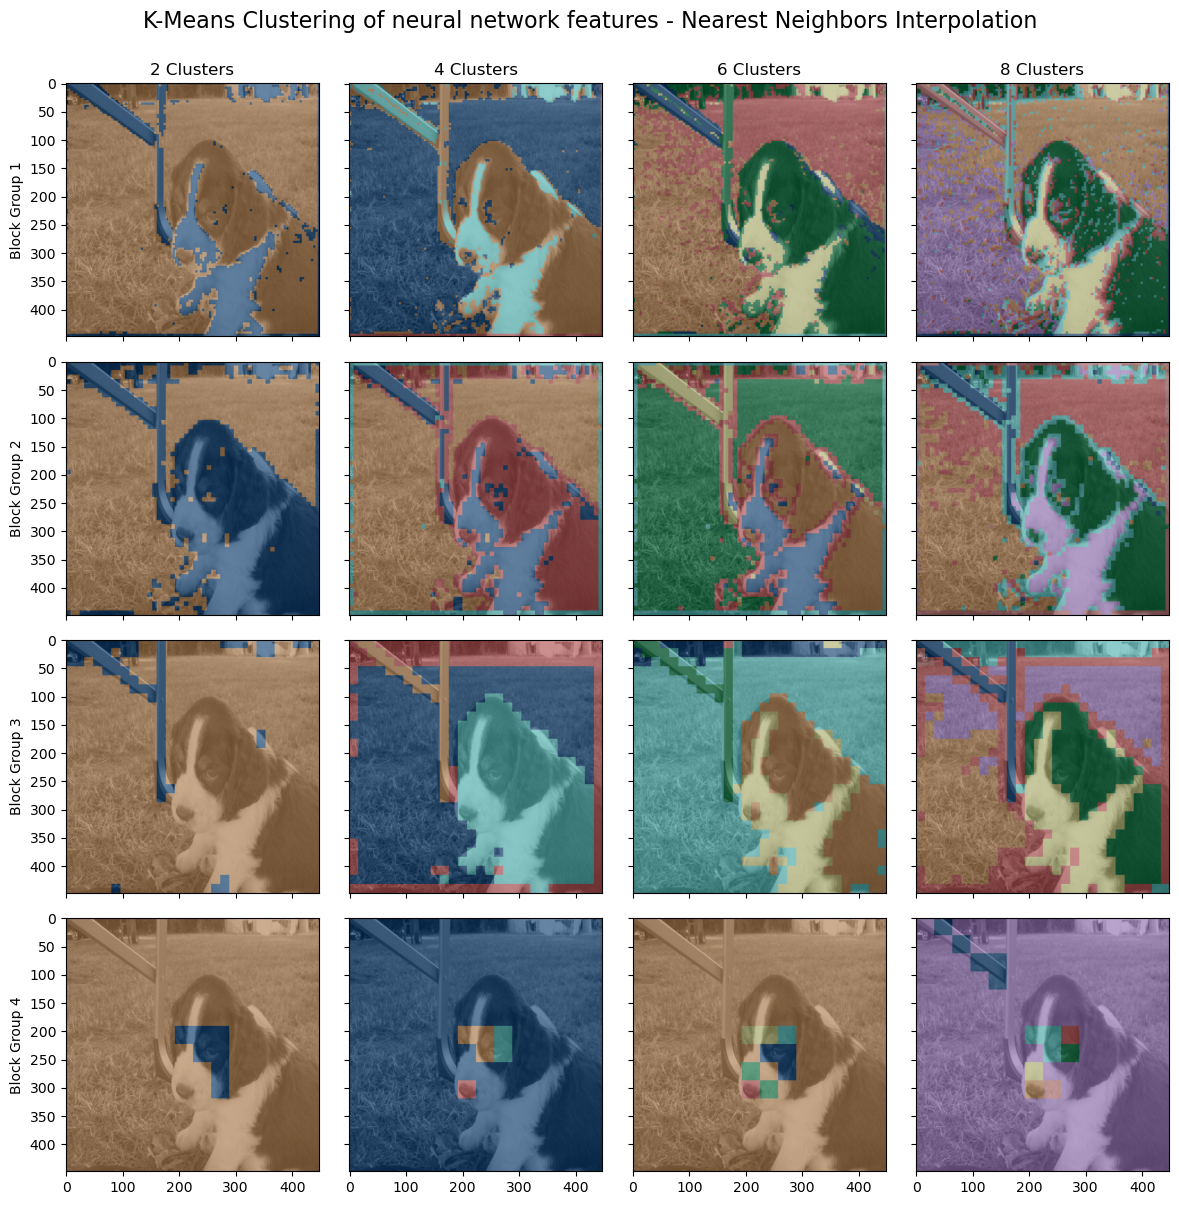

In [7]:
# Plots
for idx_batch_sample in range(batch_size):
    # Raw Image
    fig = plt.figure(figsize=(3, 3))
    plt.title("Raw Image")
    plt.imshow(img)
    plt.show()

    # Bilinear Interplation
    fig, axs = plt.subplots(nrows=len(patch_sizes), ncols=len(k_s),
                            figsize=(12, 12), sharex=True, sharey=True)
    axs = axs.flatten()
    i = 0
    for img_kmeans, ax in zip(final_images_bilinear_interp[idx_batch_sample],
                              axs):
        if i % len(k_s) == 0:
            ax.set_ylabel(f"Block Group {int((i / len(k_s)) + 1)}")
        if i < len(k_s):
            ax.title.set_text(f"{k_s[i]} Clusters")
        ax.imshow(img_kmeans)
        i += 1
    fig.suptitle(
        "K-Means Clustering of neural network features "
        + "- Bilinear Interplation",
        y=1.0, fontsize=16)
    fig.tight_layout()
    plt.show()

    # Nearest Neighbors Interpolation
    fig, axs = plt.subplots(nrows=len(patch_sizes), ncols=len(k_s),
                            figsize=(12, 12), sharex=True, sharey=True)
    axs = axs.flatten()
    i = 0
    for img_kmeans, ax in zip(final_images_nn_interp[idx_batch_sample], axs):
        if i % len(k_s) == 0:
            ax.set_ylabel(f"Block Group {int((i / len(k_s)) + 1)}")
        if i < len(k_s):
            ax.title.set_text(f"{k_s[i]} Clusters")
        ax.imshow(img_kmeans)
        i += 1
    fig.suptitle(
        "K-Means Clustering of neural network features "
        + "- Nearest Neighbors Interpolation",
        y=1.0, fontsize=16)
    fig.tight_layout()
    plt.show()

____________________Sample n. 1 of batch____________________


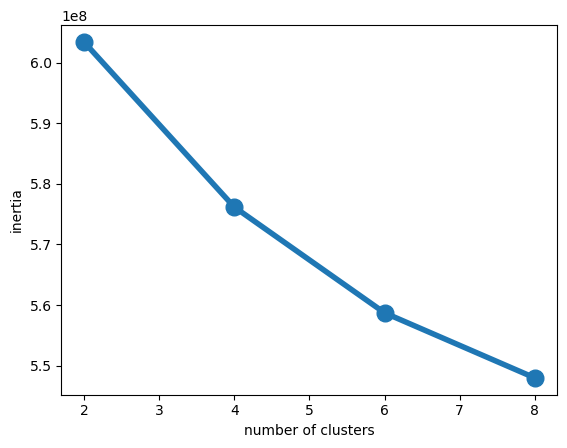

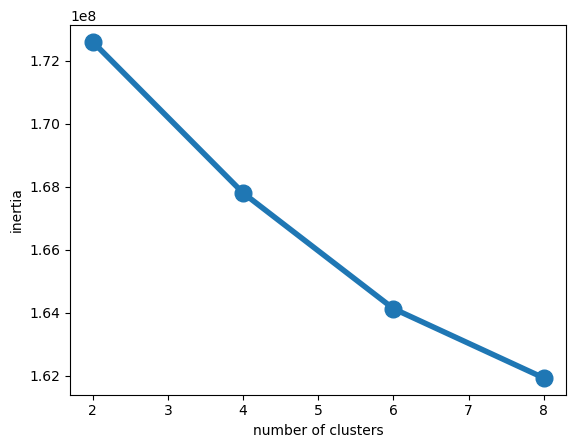

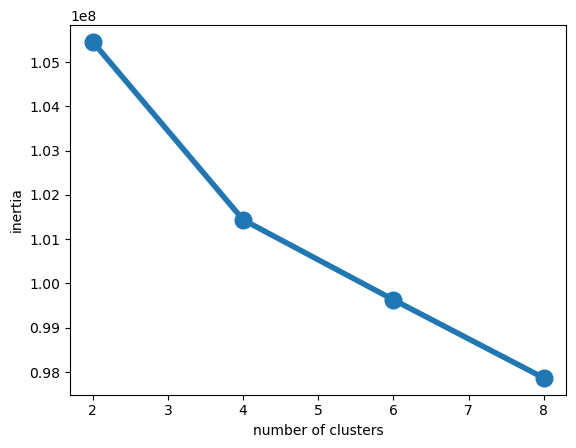

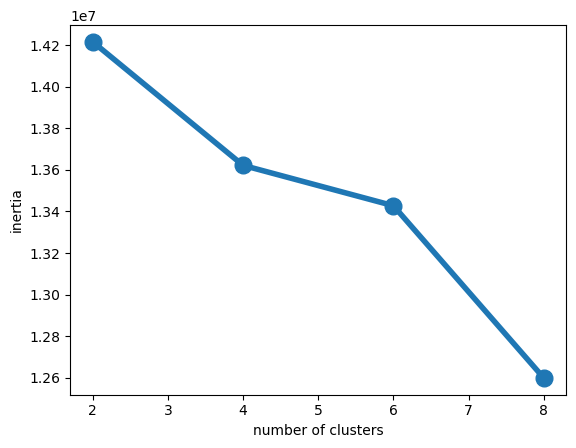

____________________Sample n. 2 of batch____________________


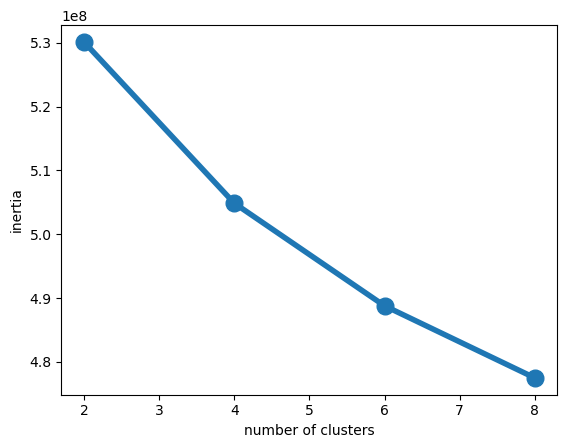

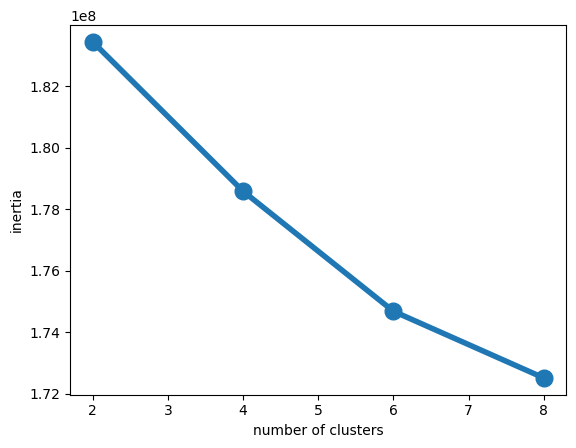

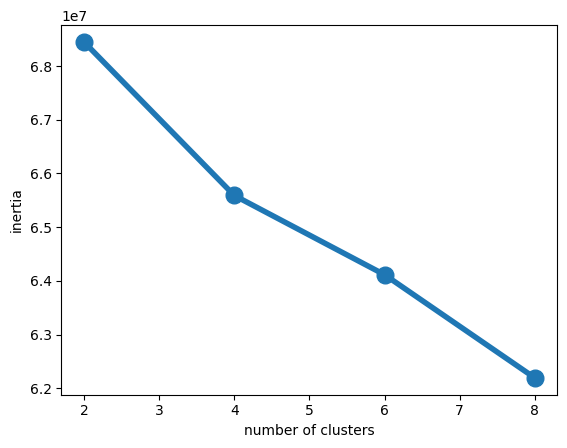

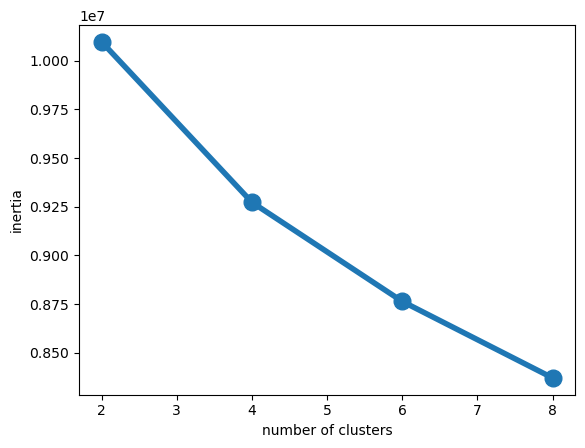

In [8]:
for idx_batch_sample in range(batch_size):
    print("_" * 20 + f"Sample n. {idx_batch_sample + 1} of batch" + "_" * 20)
    for idx in range(len(blocks_batch_paths)):
        plt.plot(k_s, compactness_k_dict[idx_batch_sample, idx], 'o-', linewidth=4, markersize=12);
        plt.xlabel('number of clusters')
        plt.ylabel('inertia')
        plt.show()

# ______________________________________________________________________________________________________

In [9]:
final_images_bilinear_interp = []
final_images_nn_interp = []

j = 0
for patch_path in patches_paths:
    patch = np.load(patch_path) #cv.imread(patch_path)

    for k in k_s:
        seg_patch = ward_on_feature(
            patch, n_clusters=k, normalize=normalize,
            n_channels=n_channels_patches[j], plot=False)
        seg_full = downsample_img(
            seg_patch, full_size, full_size, False,
            interpolation_method=bilinear_interpolation_flag)

        # Convert the original image as grayscale image to put it in the
        # background to be able to put the patch (the output of Kmeans)
        # over it in a transparent way.
        # Single channel grayscale image
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Repeat the grayscale image along all the 3 channels
        stacked_img = np.stack((img_gray,) * 3, axis=-1)
        final_img_bilinear_interp = cv.addWeighted(
            stacked_img, weight_original_img, seg_full, weight_colored_patch,
            gamma)
        final_images_bilinear_interp.append(final_img_bilinear_interp)

        seg_full_nearest_neighbor_interp = downsample_img(
            seg_patch, full_size, full_size, False,
            interpolation_method=nn_interpolation_flag)

        nearest_neighbor_interp_final_img = cv.addWeighted(
            stacked_img, weight_original_img,
            seg_full_nearest_neighbor_interp,
            weight_colored_patch, gamma)
        final_images_nn_interp.append(nearest_neighbor_interp_final_img)
    j += 1

NameError: name 'patches_paths' is not defined

In [ ]:
# Plots

# Raw Image
fig = plt.figure(figsize=(3, 3))
plt.title("Raw Image")
plt.imshow(img)
plt.show()

# Bilinear Interplation
fig, axs = plt.subplots(nrows=len(patch_sizes), ncols=len(k_s),
                        figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
i = 0
for img_ward, ax in zip(final_images_bilinear_interp, axs):
    if i % len(k_s) == 0:
        ax.set_ylabel(f"Block Group {int((i / len(k_s)) + 1)}")
    if i < len(k_s):
        ax.title.set_text(f"{k_s[i]} Clusters")
    ax.imshow(img_ward)
    i += 1
fig.suptitle(
    "Ward Hierarchical Clustering of neural network features "
    + "- Bilinear Interplation",
    y=1.0, fontsize=16)
fig.tight_layout()
plt.show()

# Nearest Neighbors Interpolation
fig, axs = plt.subplots(nrows=len(patch_sizes), ncols=len(k_s),
                        figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
i = 0
for img_ward, ax in zip(final_images_nn_interp, axs):
    if i % len(k_s) == 0:
        ax.set_ylabel(f"Block Group {int((i / len(k_s)) + 1)}")
    if i < len(k_s):
        ax.title.set_text(f"{k_s[i]} Clusters")
    ax.imshow(img_ward)
    i += 1
fig.suptitle(
    "Ward Hierarchical Clustering of neural network features '"
    + "- Nearest Neighbors Interpolation",
    y=1.0, fontsize=16)
fig.tight_layout()
plt.show()